In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch
from torch.autograd import Variable
import random
import torch.nn.functional as F
from torch.autograd import Variable as V

In [2]:
#These classes and everything within this cell is copied directly from:
#https://github.com/AdrienLE/ANIML/blob/master/ANIML.ipynb

class ModifiableModule(nn.Module):
    def params(self):
        return [p for _, p in self.named_params()]
    
    def named_leaves(self):
        return []
    
    def named_submodules(self):
        return []
    
    def named_params(self):
        subparams = []
        for name, mod in self.named_submodules():
            for subname, param in mod.named_params():
                subparams.append((name + '.' + subname, param))
        return self.named_leaves() + subparams
    
    def set_param(self, name, param):
        if '.' in name:
            n = name.split('.')
            module_name = n[0]
            rest = '.'.join(n[1:])
            for name, mod in self.named_submodules():
                if module_name == name:
                    mod.set_param(rest, param)
                    break
        else:
            setattr(self, name, param)
            
    def copy(self, other):
        for name, param in other.named_params():
            self.set_param(name, param)

class GradLinear(ModifiableModule):
    def __init__(self, *args, **kwargs):
        super().__init__()
        ignore = nn.Linear(*args, **kwargs)
        self.weights = V(ignore.weight.data, requires_grad=True)
        self.bias = V(ignore.bias.data, requires_grad=True)
        
    def forward(self, x):
        return F.linear(x, self.weights, self.bias)
    
    def named_leaves(self):
        return [('weights', self.weights), ('bias', self.bias)]

class SineModel(ModifiableModule):
    def __init__(self):
        super().__init__()
        self.hidden1 = GradLinear(1, 40)
        self.hidden2 = GradLinear(40, 40)
        self.out = GradLinear(40, 1)
        
    def forward(self, x):
        x = F.relu(self.hidden1(x))
        x = F.relu(self.hidden2(x))
        return self.out(x)
    
    def named_submodules(self):
        return [('hidden1', self.hidden1), ('hidden2', self.hidden2), ('out', self.out)]

In [3]:
class SineWaveTask:
    def __init__(self):
        self.a = np.random.uniform(0.1, 5.0)
        self.b = np.random.uniform(0, 2*np.pi)
        self.train_x = None
        
    def f(self, x):
        return self.a * np.sin(x + self.b)
        
    def training_set(self, size=10, force_new=False):
        if self.train_x is None and not force_new:
            self.train_x = np.random.uniform(-5, 5, size)
            x = self.train_x
        elif not force_new:
            x = self.train_x
        else:
            x = np.random.uniform(-5, 5, size)
        y = self.f(x)
        return torch.Tensor(x), torch.Tensor(y)
    
    def test_set(self, size=50):
        x = np.linspace(-5, 5, size)
        y = self.f(x)
        return torch.Tensor(x), torch.Tensor(y)
    
    def plot(self, *args, **kwargs):
        x, y = self.test_set(size=100)
        return plt.plot(x.numpy(), y.numpy(), *args, **kwargs)
    
    def plot_model(self, new_model, *args, **kwargs):
        x, y_true = self.test_set(size=100)
        x = Variable(x[:, None])
        y_true = Variable(y_true[:, None])    

        y_pred = new_model(x)

        plt.plot(x.data.numpy().flatten(),
                 y_pred.data.numpy().flatten(),
                 *args, **kwargs)

In [4]:
# The Minimum Square Error is used to evaluate the difference between prediction and ground truth
criterion = nn.MSELoss()

def copy_existing_model(model):
    # Function to copy an existing model
    # We initialize a new model
    new_model = Neural_Network()
    # Copy the previous model's parameters into the new model
    new_model.load_state_dict(model.state_dict())
    return new_model


def get_samples_in_good_format(wave, num_samples=10, force_new=False):
  #This function is used to sample data from a wave
  x, y_true = wave.training_set(size=num_samples, force_new=force_new)
  # We add [:,None] to get the right dimensions to pass to the model: we want K x 1 (we have scalars inputs hence the x 1)
  # Note that we convert everything torch tensors
  x = torch.tensor(x[:,None])
  y_true = torch.tensor(y_true[:,None])
  return x,y_true

def initialization_to_store_meta_losses():
  # This function creates lists to store the meta losses
  global store_train_loss_meta; store_train_loss_meta = []
  global store_test_loss_meta; store_test_loss_meta = []

def test_set_validation(model,new_model,wave,lr_inner,k,store_test_loss_meta):
    # This functions does not actually affect the main algorithm, it is just used to evaluate the new model
    new_model = training(model, wave, lr_inner, k)
    # Obtain the loss
    loss = evaluation(new_model, wave)
    # Store loss
    store_test_loss_meta.append(loss)

def train_set_evaluation(new_model,wave,store_train_loss_meta):
    loss = evaluation(new_model, wave)
    store_train_loss_meta.append(loss) 

def print_losses(epoch,store_train_loss_meta,store_test_loss_meta,printing_step=1000):
  if epoch % printing_step == 0:
    print(f'Epochh : {epoch}, Average Train Meta Loss : {np.mean(store_train_loss_meta)}, Average Test Meta Loss : {np.mean(store_test_loss_meta)}')

#This is based on the paper update rule, we calculate the difference between parameters and then this is used by the optimizer, rather than doing the update by hand
def reptile_parameter_update(model,new_model):
  # Zip models for the loop
  zip_models = zip(model.parameters(), new_model.parameters())
  for parameter, new_parameter in zip_models:
    if parameter.grad is None:
      parameter.grad = torch.tensor(torch.zeros_like(parameter))
    # Here we are adding the gradient that will later be used by the optimizer
    parameter.grad.data.add_(parameter.data - new_parameter.data)

# Define commands in order needed for the metaupdate
# Note that if we change the order it doesn't behave the same
def metaoptimizer_update(metaoptimizer):
  # Take step
  metaoptimizer.step()
  # Reset gradients
  metaoptimizer.zero_grad()

def metaupdate(model,new_model,metaoptimizer):
  # Combine the two previous functions into a single metaupdate function
  # First we calculate the gradients
  reptile_parameter_update(model,new_model)
  # Use those gradients in the optimizer
  metaoptimizer_update(metaoptimizer)

def evaluation(new_model, wave, item = True, num_samples=10, force_new=False):
    # Get data
    x, label = get_samples_in_good_format(wave,num_samples=num_samples, force_new=force_new)
    # Make model prediction
    prediction = new_model(x)
    # Get loss
    if item == True: #Depending on whether we need to return the loss value for storing or for backprop
      loss = criterion(prediction,label).item()
    else:
      loss = criterion(prediction,label)
    return loss

def training(model, wave, lr_k, k):
    # Create new model which we will train on
    new_model = copy_existing_model(model)
    # Define new optimizer
    koptimizer = torch.optim.SGD(new_model.parameters(), lr=lr_k)
    # Update the model multiple times, note that k>1 (do not confuse k with K)
    for i in range(k):
        # Reset optimizer
        koptimizer.zero_grad()
        # Evaluate the model
        loss = evaluation(new_model, wave, item = False)
        # Backpropagate
        loss.backward()
        koptimizer.step()
    return new_model

In [50]:
#Neural network configuration stems from: https://github.com/AdrienLE/ANIML/blob/master/ANIML.ipynb
# maml training
# note: uses comments and structure largely from code ocariz wrote! 
#alternative code
'''
Handling computation graphs and second-order backprop help and partial inspiration from: 
- https://discuss.pytorch.org/t/how-to-save-computation-graph-of-a-gradient/128286/2 
- https://discuss.pytorch.org/t/when-do-i-use-create-graph-in-autograd-grad/32853/3 
- https://lucainiaoge.github.io/download/PyTorch-create_graph-is-true_Tutorial_and_Example.pdf
- https://www.youtube.com/watch?v=IkDw22a8BDE
- https://discuss.pytorch.org/t/how-to-manually-update-network-parameters-while-keeping-track-of-its-computational-graph/131642/2
- https://discuss.pytorch.org/t/how-to-calculate-2nd-derivative-of-a-likelihood-function/15085/3
- https://pytorch.org/tutorials/recipes/recipes/zeroing_out_gradients.html

Neural network configuration and helper class functions copied directly from 
-https://github.com/AdrienLE/ANIML/blob/master/ANIML.ipynb


Note, different ways to refer to the task-specific vs. meta/aggregate updates to the parameters
Sometimes called "inner" and "outer" loop, respectively
Here, refered to as "task_specific" and "agg"/meta" (the latter, for consistency w/ ocariz code)
'''
torch.manual_seed(0)
random.seed(0)
np.random.seed(0)

TRAIN_SIZE = 2
TEST_SIZE = 100
VAL_SIZE = 100
SINE_TRAIN = [SineWaveTask() for _ in range(TRAIN_SIZE)]
SINE_TEST = [SineWaveTask() for _ in range(TEST_SIZE)]
SINE_VALIDATION = [SineWaveTask() for _ in range(VAL_SIZE)]

#Only works for 1 task
T = TRAIN_SIZE # num tasks
N = 1 # number of inner loop steps (notation from: https://www.bayeswatch.com/2018/11/30/HTYM/)
num_samples = 10 # number of samples to draw from the task
lr_task_specific = 0.01 # task specific learning rate
lr_meta = 0.001 # meta-update learning rate
num_epochs = 700001
printing_step = 10000 # show log of loss every x epochs

# Initializations
initialization_to_store_meta_losses()

#Instantiate the other model, from the prior class
model = SineModel()

#Use the different syntax of model.params()
meta_optimizer = torch.optim.Adam(model.params(), lr = lr_meta)

#Create a list to store the meta-losses since only storing one loss at a time
metaLosses = []
metaTrainLosses = []
metaValLosses = []
for epoch in range(num_epochs):
    
    # store loss over all tasks to then do a large meta-level update of initial params
    # idea/help from video: https://www.youtube.com/watch?v=IkDw22a8BDE
    
    #Moved this inside the function so that we sample a new batch of tasks every time
    waves = random.sample(SINE_TRAIN, T)
    
    if epoch % printing_step == 0: 
        for name, param in model.named_params():
            if name =="hidden1.weights":
                print(name, param[:5])
     
    # loop over tasks and fine-tune weights per task
    for i, T_i in enumerate(waves): 
       
        # copy model to use the same starting weights
        #Use the different copying function capacity, our function copying doesn't work with their model formulation
        new_model = SineModel()
        new_model.copy(model)
        
        # note, b/c of manual gradient updates, need to zero out the gradients at the start
        # https://pytorch.org/tutorials/recipes/recipes/zeroing_out_gradients.html
        new_model.zero_grad()

        # use model to predict on task-specific training set
        task_specific_loss = evaluation(new_model, T_i, item = False, num_samples=num_samples, force_new=False)
        
        #Run the initial loss using .backward and create the graph so that we can go back through as neeeded
        task_specific_loss.backward(create_graph=True)
            
        #manually update the parameters
        #This is adapted from the copy function which is from:
        #https://github.com/AdrienLE/ANIML/blob/master/ANIML.ipynb
        for name, param in new_model.named_params():
            new_model.set_param(name, param - lr_task_specific*param.grad)
        
        
        metaTrainLosses.append(task_specific_loss.item())
        
        # use new model to predict 
        # note: we want a new sample from T_i
        # e.g., sample new draws from task, feed forward (e.g., get preds), compute loss, sum loss to meta_loss for later gradient use
        meta_loss = evaluation(new_model, T_i, item = False, num_samples=num_samples, force_new=True)
        metaLosses.append(meta_loss.item())
        

    # backpropogate thru all tasks
    # use adam optimizer here!! 
    meta_loss.backward() 
    metaoptimizer_update(meta_optimizer)
    
    # get a sample using the validation set
    val_wave = random.sample(SINE_VALIDATION, 1)[0]
    meta_val_loss = evaluation(new_model, val_wave, item = True, num_samples=num_samples, force_new=False)
    metaValLosses.append(meta_val_loss)
    
    #Print out the average loss over the last 500 iterations
    if epoch % printing_step == 0: 
        print(f"Epoch {epoch}, Current loss: {np.mean(metaLosses)},  Train loss: {np.mean(metaTrainLosses)}, Val loss: {np.mean(metaValLosses)}")
        for name, param in model.named_params():
            if name =="hidden1.weights":
                print(name, param[:5])


hidden1.weights tensor([[-0.0075],
        [ 0.5364],
        [-0.8230],
        [-0.7359],
        [-0.3852]], grad_fn=<SliceBackward0>)
Epoch 0, Current loss: 4.0181978940963745,  Train loss: 4.5405226945877075, Val loss: 0.026613468304276466
hidden1.weights tensor([[-0.0065],
        [ 0.5374],
        [-0.8240],
        [-0.7369],
        [-0.3862]], grad_fn=<SliceBackward0>)


<ipython-input-4-326573f657c5>:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x[:,None])
<ipython-input-4-326573f657c5>:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_true = torch.tensor(y_true[:,None])


hidden1.weights tensor([[ 0.0645],
        [ 0.6010],
        [-0.6245],
        [-0.7730],
        [-0.5156]], grad_fn=<SliceBackward0>)
Epoch 10000, Current loss: 1.3794366607799904,  Train loss: 0.46839502674579897, Val loss: 8.18826452265587
hidden1.weights tensor([[ 0.0649],
        [ 0.6013],
        [-0.6241],
        [-0.7735],
        [-0.5161]], grad_fn=<SliceBackward0>)
hidden1.weights tensor([[ 0.0981],
        [ 0.6271],
        [-0.5139],
        [-0.7991],
        [-0.5592]], grad_fn=<SliceBackward0>)
Epoch 20000, Current loss: 1.3305556511497219,  Train loss: 0.3884536992466278, Val loss: 8.203872013387386
hidden1.weights tensor([[ 0.0981],
        [ 0.6271],
        [-0.5137],
        [-0.7991],
        [-0.5592]], grad_fn=<SliceBackward0>)
hidden1.weights tensor([[ 0.1184],
        [ 0.6586],
        [-0.4739],
        [-0.8165],
        [-0.5784]], grad_fn=<SliceBackward0>)
Epoch 30000, Current loss: 1.297285673100536,  Train loss: 0.3535755534896091, Val loss: 8.221

hidden1.weights tensor([[ 0.1637],
        [ 0.9127],
        [-0.6375],
        [-0.9243],
        [-0.6895]], grad_fn=<SliceBackward0>)
Epoch 230000, Current loss: 1.2425692295497648,  Train loss: 0.2661708982883028, Val loss: 8.217660626448998
hidden1.weights tensor([[ 0.1638],
        [ 0.9130],
        [-0.6379],
        [-0.9244],
        [-0.6896]], grad_fn=<SliceBackward0>)
hidden1.weights tensor([[ 0.1670],
        [ 0.9335],
        [-0.6513],
        [-0.9204],
        [-0.6932]], grad_fn=<SliceBackward0>)
Epoch 240000, Current loss: 1.2423536041586856,  Train loss: 0.2654107665754986, Val loss: 8.226770058397397
hidden1.weights tensor([[ 0.1669],
        [ 0.9334],
        [-0.6513],
        [-0.9205],
        [-0.6931]], grad_fn=<SliceBackward0>)
hidden1.weights tensor([[ 0.1667],
        [ 0.9247],
        [-0.6696],
        [-0.9284],
        [-0.6961]], grad_fn=<SliceBackward0>)
Epoch 250000, Current loss: 1.2420745125479897,  Train loss: 0.26468002267924573, Val loss: 

KeyboardInterrupt: 

In [81]:
true_funcs = []
init_funcs = [] 
fitted_funcs = []
for func in SINE_TRAIN: 
    x, label = get_samples_in_good_format(SINE_TRAIN[1],num_samples=100, force_new=True)
    # Make model prediction
    prediction = model(x)

    input_coords = x.detach().numpy()[:,0]
    y_pred = prediction.detach().numpy()[:,0]
    pred_data = sorted([(x, y) for (x, y) in zip(input_coords, y_pred)], key=lambda x: x[0])
    true_vals = sorted([(x, y) for (x, y) in zip(input_coords, label)], key=lambda x: x[0])
    
    true_funcs.append(true_vals)
    init_funcs.append(pred_data)
    
    new_model = SineModel()
    new_model.copy(model)

    # note, b/c of manual gradient updates, need to zero out the gradients at the start
    # https://pytorch.org/tutorials/recipes/recipes/zeroing_out_gradients.html
    new_model.zero_grad()

    # use model to predict on task-specific training set
    task_specific_loss = criterion(prediction,label)

    #Run the initial loss using .backward and create the graph so that we can go back through as neeeded
    task_specific_loss.backward(create_graph=True)

    #manually update the parameters
    #This is adapted from the copy function which is from:
    #https://github.com/AdrienLE/ANIML/blob/master/ANIML.ipynb
    for name, param in new_model.named_params():
        new_model.set_param(name, param - lr_task_specific*param.grad)
        
    fitted_preds = new_model(x)
    fitted_y_pred = fitted_preds.detach().numpy()[:,0]
    fitted_pred_data = sorted([(x, y) for (x, y) in zip(input_coords, fitted_y_pred)], key=lambda x: x[0])
    fitted_funcs.append(fitted_pred_data)

<ipython-input-4-326573f657c5>:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x[:,None])
<ipython-input-4-326573f657c5>:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_true = torch.tensor(y_true[:,None])


In [82]:
# fig, ax = plt.subplots()
# ax.plot(np.array(data)[:,0], np.array(data)[:,1], label="Preds")
# ax.plot(np.array(true_vals)[:,0], np.array(true_vals)[:,1], label="True Vals")
# ax.legend()

<ipython-input-83-fff236352f8e>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ax.plot(np.array(true_vals)[:,0], np.array(true_vals)[:,1], label="True Vals")


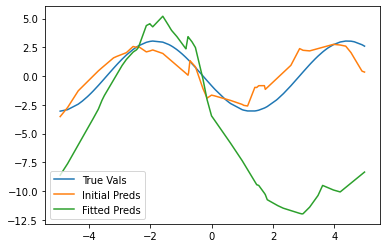

In [83]:
current_func = 0
fig, ax = plt.subplots()
data = fitted_funcs[current_func]
true_vals = true_funcs[current_func]
init_vals = init_funcs[current_func]
ax.plot(np.array(true_vals)[:,0], np.array(true_vals)[:,1], label="True Vals")
ax.plot(np.array(init_vals)[:,0], np.array(init_vals)[:,1], label="Initial Preds")
ax.plot(np.array(data)[:,0], np.array(data)[:,1], label="Fitted Preds")
ax.legend()

In [73]:
init_funcs[0][0], fitted_funcs[0][0]

((-4.9895883, -3.689345), (-4.9895883, -3.689345))